In [1]:
# Import standard library modules
import sys

# Set the relative path to the project root directory
relative_path_to_root = "../../"

# Add the project root to the system path for importing in-house modules
sys.path.append(relative_path_to_root)

# Import in-house modules from the 'utilities' package
from utilities import calculate_bollinger_bands, calculate_rsi
from utilities import print_title, print_label, print_footer

In [2]:
# Import libraries for data analysis and visualization
import pandas as pd
import numpy as np
import yfinance as yf # Yahoo Finance data retrieval

# Import libraries for signal processing and peak detection
from scipy.signal import find_peaks

# Import libraries for plotting and visualization
import matplotlib.pyplot as plt
import hvplot.pandas
import holoviews as hv
hv.extension('bokeh') # Use Bokeh as the backend for Holoviews

In [3]:
# Set display options for Pandas (optional, but often helpful)
pd.set_option('display.float_format', lambda x: '%.3f' % x) # Suppress scientific notation

In [4]:
# Fetch S&P 500 tickers
#Define dates
start_date = '2000-01-01'
end_date = '2024-10-14'

#Get tickers from wikipedia
sp500_tickers = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]['Symbol'].tolist()

# Filter out Class B shares that have a '.B' in the ticker name
sp500_tickers = [ticker for ticker in sp500_tickers if '.B' not in ticker]

# print(f"Initial total S&P 500 tickers: {len(sp500_tickers)}")
print_title("Initial total S&P 500 tickers: " + str(len(sp500_tickers)), closed_corners=True)

╔═══════════════════════════════════════════════════════════════╗
║              Initial total S&P 500 tickers: 501               ║
╚═══════════════════════════════════════════════════════════════╝


In [5]:
# Download historical prices
data = yf.download(sp500_tickers, start=start_date, end=end_date)['Adj Close']

# Fill NaN values with 0
data.fillna(0, inplace=True)

# Check if data was downloaded for all tickers
print(f"Successfully downloaded tickers: {len(data.columns)} out of {len(sp500_tickers)}")

[*********************100%***********************]  501 of 501 completed


Successfully downloaded tickers: 501 out of 501


In [6]:
# Display data Frame
data.head()

Ticker,A,AAPL,ABBV,ABNB,ABT,ACGL,ACN,ADBE,ADI,ADM,...,WTW,WY,WYNN,XEL,XOM,XYL,YUM,ZBH,ZBRA,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2000-01-03 00:00:00+00:00,43.463,0.844,0.000,0.000,8.288,1.278,0.000,16.275,28.215,6.307,...,0.000,11.353,0.000,6.848,18.036,0.000,4.634,0.000,25.028,0.000
2000-01-04 00:00:00+00:00,40.143,0.773,0.000,0.000,8.051,1.271,0.000,14.909,26.787,6.242,...,0.000,10.926,0.000,7.006,17.690,0.000,4.541,0.000,24.667,0.000
2000-01-05 00:00:00+00:00,37.653,0.784,0.000,0.000,8.037,1.389,0.000,15.204,27.178,6.143,...,0.000,11.505,0.000,7.276,18.655,0.000,4.564,0.000,25.139,0.000
2000-01-06 00:00:00+00:00,36.219,0.716,0.000,0.000,8.318,1.375,0.000,15.328,26.435,6.176,...,0.000,12.043,0.000,7.209,19.619,0.000,4.526,0.000,23.778,0.000
2000-01-07 00:00:00+00:00,39.237,0.750,0.000,0.000,8.407,1.451,0.000,16.073,27.178,6.274,...,0.000,11.647,0.000,7.209,19.562,0.000,4.425,0.000,23.514,0.000


In [7]:
# Display tickers that were successfully downloaded
downloaded_tickers = data.columns.get_level_values(0).unique()
print(f"Successfully downloaded tickers: {len(downloaded_tickers)} out of {len(sp500_tickers)}")

Successfully downloaded tickers: 501 out of 501


In [8]:
# Calculate various indicators
volatility = data.pct_change()

# Handle inf values in the volatility DataFrame
volatility.replace([np.inf, -np.inf], np.nan, inplace=True)

# Fill missing values
volatility.ffill(inplace=True)
volatility.bfill(inplace=True)

rsi = data.apply(calculate_rsi)
sma_50 = data.rolling(window=50).mean()
sma_100 = data.rolling(window=100).mean()
sma_200 = data.rolling(window=200).mean()
upper_band, lower_band = calculate_bollinger_bands(data)
support = data.rolling(window=50).min()
resistance = data.rolling(window=50).max()


In [9]:
# Align data lengths by filling forward and backward
volatility.ffill(inplace=True)
volatility.bfill(inplace=True)
rsi.ffill(inplace=True)
rsi.bfill(inplace=True)
sma_50.ffill(inplace=True)
sma_50.bfill(inplace=True)
sma_100.ffill(inplace=True)
sma_100.bfill(inplace=True)
sma_200.ffill(inplace=True)
sma_200.bfill(inplace=True)
upper_band.ffill(inplace=True)
upper_band.bfill(inplace=True)
lower_band.ffill(inplace=True)
lower_band.bfill(inplace=True)
support.ffill(inplace=True)
support.bfill(inplace=True)
resistance.ffill(inplace=True)
resistance.bfill(inplace=True)

In [10]:
print(f"Volatility shape: {volatility.shape}")
print(volatility.head())

print(f"RSI shape: {rsi.shape}")
print(rsi.head())

print(f"SMA_50 shape: {sma_50.shape}")
print(sma_50.head())

print(f"SMA_100 shape: {sma_100.shape}")
print(sma_100.head())

print(f"SMA_200 shape: {sma_200.shape}")
print(sma_200.head())

print(f"Upper Band shape: {upper_band.shape}")
print(upper_band.head())

print(f"Lower Band shape: {lower_band.shape}")
print(lower_band.head())

print(f"Support shape: {support.shape}")
print(support.head())

print(f"Resistance shape: {resistance.shape}")
print(resistance.head())

Volatility shape: (6234, 501)
Ticker                         A   AAPL   ABBV   ABNB    ABT   ACGL    ACN  \
Date                                                                         
2000-01-03 00:00:00+00:00 -0.076 -0.084 -0.008 -0.038 -0.029 -0.005 -0.011   
2000-01-04 00:00:00+00:00 -0.076 -0.084 -0.008 -0.038 -0.029 -0.005 -0.011   
2000-01-05 00:00:00+00:00 -0.062  0.015 -0.008 -0.038 -0.002  0.093 -0.011   
2000-01-06 00:00:00+00:00 -0.038 -0.087 -0.008 -0.038  0.035 -0.010 -0.011   
2000-01-07 00:00:00+00:00  0.083  0.047 -0.008 -0.038  0.011  0.056 -0.011   

Ticker                      ADBE    ADI    ADM  ...    WTW     WY  WYNN  \
Date                                            ...                       
2000-01-03 00:00:00+00:00 -0.084 -0.051 -0.010  ... -0.003 -0.038 0.000   
2000-01-04 00:00:00+00:00 -0.084 -0.051 -0.010  ... -0.003 -0.038 0.000   
2000-01-05 00:00:00+00:00  0.020  0.015 -0.016  ... -0.003  0.053 0.000   
2000-01-06 00:00:00+00:00  0.008 -0.027  0.005  

In [11]:
# Compile indicators into a single DataFrame
length = len(data) * len(data.columns)
indicators_df = pd.DataFrame({
    'Date': np.repeat(data.index, len(data.columns)),
    'Ticker': np.tile(data.columns, len(data)),
    'Adjusted Close': data.values.flatten(),
    'Volatility': volatility.values.flatten(),
    'RSI': rsi.values.flatten(),
    'SMA_50': sma_50.values.flatten(),
    'SMA_100': sma_100.values.flatten(),
    'SMA_200': sma_200.values.flatten(),
    'Upper Band': upper_band.values.flatten(),
    'Lower Band': lower_band.values.flatten(),
    'Support': support.values.flatten(),
    'Resistance': resistance.values.flatten(),
})

# Drop NaN values
indicators_df.dropna(subset=['Adjusted Close', 'Volatility', 'RSI', 'SMA_50', 'SMA_100', 'SMA_200', 'Upper Band', 'Lower Band', 'Support', 'Resistance'], inplace=True)

# Display DataFrame
print(indicators_df.head())

                       Date Ticker  Adjusted Close  Volatility     RSI  \
0 2000-01-03 00:00:00+00:00      A          43.463      -0.076  44.942   
1 2000-01-03 00:00:00+00:00   AAPL           0.844      -0.084  49.521   
2 2000-01-03 00:00:00+00:00   ABBV           0.000      -0.008 100.000   
3 2000-01-03 00:00:00+00:00   ABNB           0.000      -0.038 100.000   
4 2000-01-03 00:00:00+00:00    ABT           8.288      -0.029  27.934   

   SMA_50  SMA_100  SMA_200  Upper Band  Lower Band  Support  Resistance  
0  53.148   55.094   45.252      44.085      37.469   36.219      95.981  
1   0.835    0.865    0.799       0.887       0.671    0.657       0.983  
2   0.000    0.000    0.000       0.000       0.000    0.000       0.000  
3   0.000    0.000    0.000       0.000       0.000    0.000       0.000  
4   7.847    8.408    9.378       8.738       6.952    7.050       8.582  


In [12]:
indicators_df.head()

,Date,Ticker,Adjusted Close,Volatility,RSI,SMA_50,SMA_100,SMA_200,Upper Band,Lower Band,Support,Resistance
0,2000-01-03 00:00:00+00:00,A,43.463,-0.076,44.942,53.148,55.094,45.252,44.085,37.469,36.219,95.981
1,2000-01-03 00:00:00+00:00,AAPL,0.844,-0.084,49.521,0.835,0.865,0.799,0.887,0.671,0.657,0.983
2,2000-01-03 00:00:00+00:00,ABBV,0.000,-0.008,100.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
3,2000-01-03 00:00:00+00:00,ABNB,0.000,-0.038,100.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
4,2000-01-03 00:00:00+00:00,ABT,8.288,-0.029,27.934,7.847,8.408,9.378,8.738,6.952,7.050,8.582


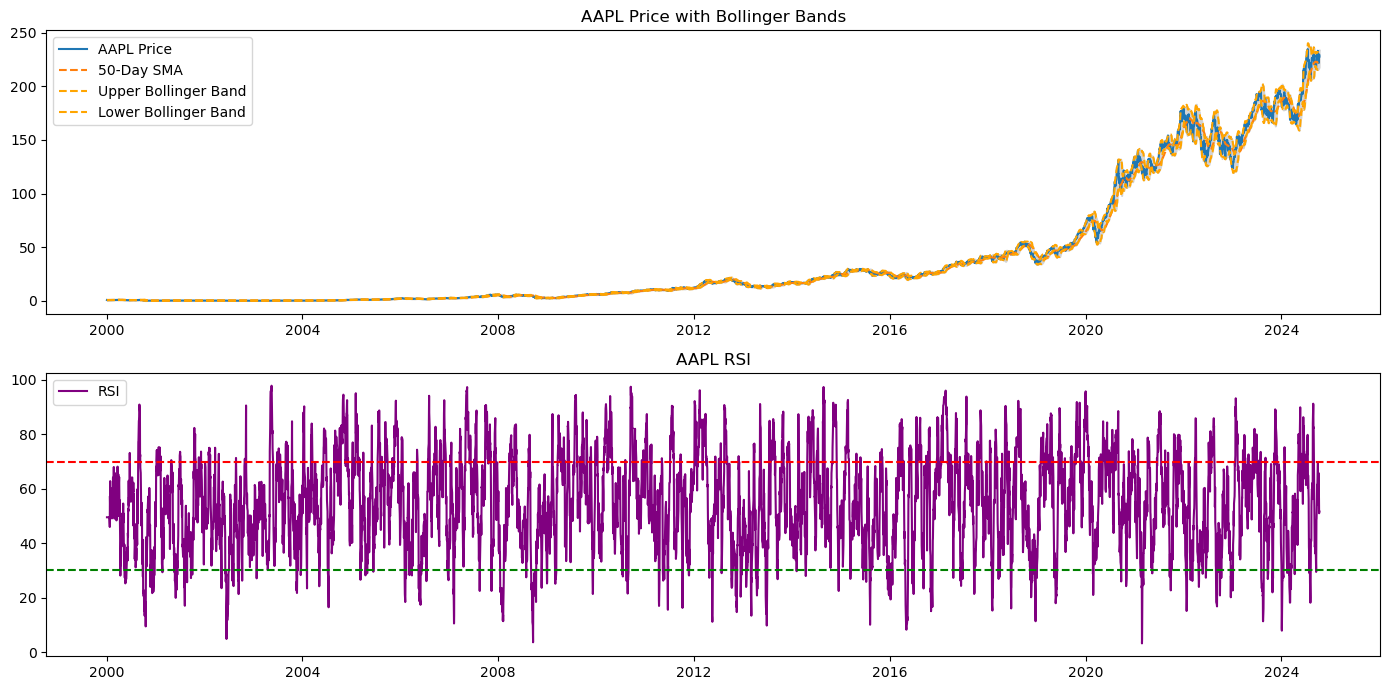

In [13]:
# Plot RSI and Bollinger Bands for a sample stock (e.g., AAPL)
ticker_sample = 'AAPL'
plt.figure(figsize=(14, 7))
plt.subplot(2, 1, 1)
plt.plot(data[ticker_sample], label=f'{ticker_sample} Price')
plt.plot(sma_50[ticker_sample], label='50-Day SMA', linestyle='--')
plt.plot(upper_band[ticker_sample], label='Upper Bollinger Band', linestyle='--', color='orange')
plt.plot(lower_band[ticker_sample], label='Lower Bollinger Band', linestyle='--', color='orange')
plt.fill_between(data.index, lower_band[ticker_sample], upper_band[ticker_sample], color='lightgray')
plt.legend()
plt.title(f'{ticker_sample} Price with Bollinger Bands')
plt.subplot(2, 1, 2)
plt.plot(rsi[ticker_sample], label='RSI', color='purple')
plt.axhline(70, color='red', linestyle='--')
plt.axhline(30, color='green', linestyle='--')
plt.legend()
plt.title(f'{ticker_sample} RSI')
plt.tight_layout()
plt.show()

In [14]:
# Prepare data for plotting
ticker_sample = 'AAPL'
data_sample = data[[ticker_sample]].copy()
data_sample['SMA_50'] = sma_50[ticker_sample]
data_sample['SMA_100'] = sma_100[ticker_sample]
data_sample['SMA_200'] = sma_200[ticker_sample]
data_sample['RSI'] = rsi[ticker_sample]
data_sample['Support'] = support[ticker_sample]
data_sample['Resistance'] = resistance[ticker_sample]

# Plot
price_plot = data_sample.hvplot.line(y=[ticker_sample, 'SMA_50', 'SMA_100', 'SMA_200'], title=f'{ticker_sample} Price with Bollinger Bands, SMA, and Resistance Levels', ylabel='Price')
support_resistance_plot = data_sample.hvplot.line(y=['Support', 'Resistance'], line_dash='dashed', color=['green', 'red'])
rsi_plot = data_sample.hvplot.line(y='RSI', title=f'{ticker_sample} RSI', ylabel='RSI').opts(yformatter='%.0f') * hv.HLine(70).opts(color='red', line_dash='dashed') * hv.HLine(30).opts(color='green', line_dash='dashed')

(price_plot * support_resistance_plot + rsi_plot).cols(1)


:Layout
   .Overlay.I  :Overlay
      .NdOverlay.I  :NdOverlay   [Ticker]
         :Curve   [Date]   (value)
      .NdOverlay.II :NdOverlay   [Ticker]
         :Curve   [Date]   (value)
   .Overlay.II :Overlay
      .Curve.I  :Curve   [Date]   (RSI)
      .HLine.I  :HLine   [x,y]
      .HLine.II :HLine   [x,y]